## Introduction
Computer and network security are heavily reliant on data in order to detect malicious behavior. The growth of the number of devices connected has resulted in traditional analytic methods that are no longer sufficient. Security professionals are increasingly presented with large volumes of computer and network data with which to attempt to detect anomolous or malicious behavior. The sources of cyber security data available for analysis can be broken into two broad classes: data from that was collected from the network and data collected from individual devices or hosts. Both sources have their strengths and weaknesses when attempting to detect anamolous or malicious behavior. One challenge with network data in the real world is the shear volume of data and the relatively high percentage that is begnign. This is what we will work to overcome in this tutorial. 

The first conceptualization of statistical anamoly detection in an Intrusion Detection System for network security was made in 1980 at the NSA [(link)](https://en.wikipedia.org/wiki/Intrusion_detection_system#Development). Neural networks were first thrown against the security problem from 1990-1992. And yet, computer and network security remains an unsolved problem, otherwise we would all have perfectly secure systems and networks. As such, there is no single methodology, tool, or approach that will always work. Instead, the domain continues to rely on highly trained individuals to apply their insights in conjunction with ever evolving techniques to get the best result. 

In this tutorial, we will cover some of the methodologies and tools available to begin to apply data science techniques towards the network security problem set. I hope you leave this tutorial with a better understanding of just some challenges that exist in security field and maybe a few ideas for new approaches.

Let's Get Started!

### Tutorial Content

In this tutorial we be using the following tools:
- [scapy](https://scapy.net/)
- [Zeek](https://www.zeek.org/)
- [Bro Analysis Tools](https://github.com/SuperCowPowers/bat).

In practice we would apply these techniques to PCAP collected from a networking device on our network. For the purpose of this tutorial we will use publically available PCAP [maccdc2012_0003.pcap](https://download.netresec.com/pcap/maccdc-2012/maccdc2012_00003.pcap.gz) , and [http.pcap](http://www.bro.org/bro-workshop-2011/solutions/logs/http.pcap). Make sure to download both files and extract the `maccdc2012_0003.pcap.gz`. The code below will function without it extracted, but it will run much more slowly.

We will also be using the two Zeek log files included with this tutorial, `dns.log` and `conn.log`. The file with the data can downloaded from [HERE](https://drive.google.com/open?id=15K8rZU_SUFc9nsuHasFCSMabF0edQvwC) **(Note: you need to be logged in with your CMU account)**. These logs were generated based on the complete `maccdc2012` data set and were made available by [Kitware](https://data.kitware.com/). Make sure to download and extract the data, we will check this is complete later.

The following topics will be covered:
- [Installing the Libraries](#Installing-the-Libraries)
- [Gathering Basic Information with Scapy](#Gathering-Basic-Information-with-Scapy)
- [Post Processing PCAP with Zeek](#Post-Processing-PCAP-with-Zeek)
- [Ingesting Zeek Logs with BAT](#Ingesting-Zeek-Logs-with-BAT)
- [Analyzing a Zeek DNS Log](#Analyzing-a-Zeek-DNS-Log)
- [Analyzing a Zeek CONN Log](#Analyzing-a-Zeek-CONN-Log)
- [Summary and References](#Summary)
- [Appendix: Zeek Installation Guide](#Appendix:-Zeek-Installation-Guide)

## Installing the Libraries

We will begin by installing our two relevant Python libraries. You can install the following packages using `pip`:

    $ pip install scapy
$ pip install bat

All of the relevant libraries are included in the provided `requirements.txt`:

    $ pip install -r requirements.txt

We can verify that all of the packages were installed correctly by running the command below:

In [1]:
from scapy.utils import RawPcapReader

import bat
from bat.log_to_dataframe import LogToDataFrame
log_to_df = LogToDataFrame()

import datetime
import pathlib
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

Let's make sure we have the correct files downloaded and extracted. 

In [2]:
dns = pathlib.Path('./dns.log')
conn = pathlib.Path('./conn.log')
if dns.exists(): 
    print("The dns.log is ready to go!")
else: 
    raise ValueError('You need to get the extracted dns.log file!')
if conn.exists(): 
    print("The conn.log is ready to go!")
else:
    raise ValueError('You need to get the extracted conn.log file!')

The dns.log is ready to go!
The conn.log is ready to go!


## Gathering Basic Information with Scapy
To begin processing network data it is useful to understand the scale of the probem. The tool that we will use to help us understand the scale of our data is Scapy. Scapy is a native Python library that will allow us to gather some basic information about PCAPs. The most obvious metric to understand the scale of a particular network capture is to count the number of packets. To do this, we can use the basic structure below. 

In [3]:
def basic_info(file_name = './http.pcap'):
    count = 0
    for (pkt_data, pkt_metadata) in RawPcapReader(file_name):
        count += 1
    print('{} contains {} packets'.format(file_name, count))

We can see that for a relatively small pcap like `http.pcap`, getting some simple information like packet counts is reasonable. However, if we compare that to getting the same information from a larger pcap like `maccdc2012_00003.pcap` we see that this becomes much slower.

In [4]:
%%time
basic_info()

./http.pcap contains 4767 packets
Wall time: 14 ms


In [5]:
%%time
basic_info('./maccdc2012_00003.pcap')

./maccdc2012_00003.pcap contains 1791239 packets
Wall time: 3.16 s


So we now know the raw number of packets in each of our captures, but lets get a little more refined information to understand our scale. If we look further into the Scapy documentation, we see that we can gather other useful information from the RawPcapReader [here](https://scapy.readthedocs.io/en/latest/api/scapy.utils.html?highlight=rawpcapreader#scapy.utils.RawPcapReader). For example, we see that `pkt.metadata` has time information. Let's use this to find the time that the first and last packets were captured and compute the total capture time. Below we extend our `basic_info` function to capture this information.

In [6]:
def basic_info_time(file_name = './http.pcap'):
    count = 0
    for (pkt_data, pkt_metadata) in RawPcapReader(file_name):
        if count == 0:
            first_time = datetime.datetime.fromtimestamp(pkt_metadata.sec)
        last_time = datetime.datetime.fromtimestamp(pkt_metadata.sec)
        count += 1

    print('{} contains {} packets'.format(file_name, count))
    print('first packet time: %s' %first_time.strftime('%Y-%m-%d %H:%M:%S'))
    print('first packet time: %s' %last_time.strftime('%Y-%m-%d %H:%M:%S'))
    print('the capture duration is: %s' %(last_time-first_time))

When we look at the resulting information, we see that despite the large difference in size `http.pcap` and `maccdc2012_00003.pcap` cover roughly the same duration. 

In [7]:
%%time
basic_info_time()

./http.pcap contains 4767 packets
first packet time: 2011-11-02 20:19:14
first packet time: 2011-11-02 20:21:23
the capture duration is: 0:02:09
Wall time: 15 ms


In [8]:
%%time
basic_info_time('./maccdc2012_00003.pcap')

./maccdc2012_00003.pcap contains 1791239 packets
first packet time: 2012-03-16 10:29:32
first packet time: 2012-03-16 10:33:20
the capture duration is: 0:03:48
Wall time: 4.44 s


The size of the data sets will quickly make this unmanageable. Instead, we will turn to a couple of tools that will post-process our raw PCAP data and bring it to a more manageable size and format for analysis. To do this we will use the Zeek network analysis framework (formerly known as Bro) and the Bro Analytic Toolset (BAT).

## Post Processing PCAP with Zeek
I will breifly cover the method for quickly processing a raw PCAP file with Zeek, however the resulting log files are included with the notebook so this step is mainly informational. The full installation guide for Zeek is in the [Appendix](#Appendix:-Zeek-Installation-Guide). 

Zeek is an open-source software framework for analyzing network traffic. It is most commonly used to detect behavioral anomalies within network data. Zeek does this by converting raw network data into higher-level events and then providing a complete scripting language to interact with those events. We will be using the first stage, the conversion from raw network data into high-level events, to:

- Extract useful metadata from our original data

    **AND**

- Categorize the metadata, in log form, for further analysis. 

To generate the standard set of log files using the default Zeek rules, we issue the following command:

    $ zeek -r http.pcap
$ zeek -r maccdc2012_00003.pcap

You can read about the various different log files that are generated [HERE](https://docs.zeek.org/en/stable/examples/logs/index.html#working-with-log-files), but we will be working with the the `dns.log` and `conn.log` files from the complete `maccdc` data set going forward. We already ensured that we have the files on hand, so let's get started!

## Ingesting Zeek Logs with BAT

So now that we have our log files, what do we do? From a strategic perspective, this is where we rely on our domain expertise to give us an initial direction. In this case, we will start by working with the `dns.log`. We chose the `dns.log` because any attackers on the network, unless they hardcoded their IP address, they will need to use DNS resolution to communicate. In some instances, they have been known to also exfiltrate data and conduct command and control over DNS by using crafted queries. The second advantage is that the `dns.log` size is much smaller than the `conn.log`, so it is relatively easy for us to process quickly and pivot into a larger, denser log. 

The first step is for us to pull the dns.log file into `pandas`, which we accomplish with the BAT `log_to_df` method seen below. 

In [9]:
%%time
# Pull dns.log into a pandas dataframe
dns_df = log_to_df.create_dataframe('./dns.log')

Wall time: 5.66 s


In [10]:
# Checking the length of the log
len(dns_df)

427935

That one line is all it takes! We can now look at what we have in the dataframe and what we can do with it.

### Analyzing a Zeek DNS Log

In [11]:
dns_df.head()

,uid,id.orig_h,id.orig_p,id.resp_h,id.resp_p,proto,trans_id,query,qclass,qclass_name,...,rcode,rcode_name,AA,TC,RD,RA,Z,answers,TTLs,rejected
ts,,,,,,,,,,,,,,,,,,,,,
2012-03-16 12:30:05.509999989,CWGtK431H9XuaTN4fi,192.168.202.100,45658,192.168.27.203,137,udp,33008,*\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\...,1,C_INTERNET,...,0,NOERROR,F,F,F,F,1,NaN,NaN,F
2012-03-16 12:30:15.069999933,C36a282Jljz7BsbGH,192.168.202.76,137,192.168.202.255,137,udp,57402,HPE8AA67,1,C_INTERNET,...,NaN,NaN,F,F,T,F,1,NaN,NaN,F
2012-03-16 12:30:15.819999933,C36a282Jljz7BsbGH,192.168.202.76,137,192.168.202.255,137,udp,57402,HPE8AA67,1,C_INTERNET,...,NaN,NaN,F,F,T,F,1,NaN,NaN,F
2012-03-16 12:30:16.569999933,C36a282Jljz7BsbGH,192.168.202.76,137,192.168.202.255,137,udp,57402,HPE8AA67,1,C_INTERNET,...,NaN,NaN,F,F,T,F,1,NaN,NaN,F
2012-03-16 12:30:05.859999895,C36a282Jljz7BsbGH,192.168.202.76,137,192.168.202.255,137,udp,57398,WPAD,1,C_INTERNET,...,NaN,NaN,F,F,T,F,1,NaN,NaN,F


Now what? In a typical cyber security application, like in most data science, when we don't have any prior knowledge of the data set we begin by gathering basic information about the data we have captured.

The first thing that we can look at is the different basic protocols that are present in the DNS log. We would expect to primarily see UDP traffic, though some TCP can be present. This is exaclty what we see below. 

In [12]:
# Counting the DNS queries by protocol type
dns_df['proto'].value_counts()

udp    427063
tcp       872
Name: proto, dtype: int64

As we discussed before, the most interesting part of the `dns.log` is the query field. So lets start by doing a quick 'tails' analysis of the most and least frequent queries in our set to see what we find.

In [13]:
# Look at the head and tail queries by count
queries = dns_df.groupby(['query']).size().sort_values(ascending=False)
print("----- Top Queries -----")
print(queries.head(10))
print("----- Bottom Queries -----")
print(queries.tail(10))

----- Top Queries -----
query
teredo.ipv6.microsoft.com                                    39273
tools.google.com                                             14057
www.apple.com                                                13390
time.apple.com                                               13109
safebrowsing.clients.google.com                              11658
*\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00    10401
WPAD                                                          9134
44.206.168.192.in-addr.arpa                                   7248
HPE8AA67                                                      6929
ISATAP                                                        6569
dtype: int64
----- Bottom Queries -----
query
153.229.168.192.misc.dnsbl.sorbs.net                                        1
153.229.168.192.sbl.spamhaus.org                                            1
153.229.168.192.socks.dnsbl.sorbs.net                                       1
noscript.net        

It looks like we have some potentially interesting queries in both the head and tail of our query analysis. Queries like `*\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00*` and `6.8.e.9.e.4.e.f.f.f.9.2.c.0.2.0.0.0.0.0.0.0.0.0.0.0.0.0.0.8.e.f.ip6.arpa` certainly look unusual. We also notice that they are longer queries than the others in the set (though some of the shorter queries would also warrant further investigation). Let's use that insight to add a 'query_len' column to our dataframe.

In [14]:
# Adding a query length field to the dataframe
dns_df['query_len'] = dns_df['query'].str.len()

With the `query_len` field added, lets get some basic information and make a quick plot to see the general distribution of the lengths in our dataframe.

count    424287.000000
mean         19.086057
std          10.882549
min           1.000000
25%          13.000000
50%          16.000000
75%          25.000000
max          86.000000
Name: query_len, dtype: float64


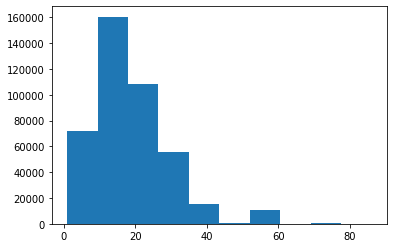

In [16]:
# Getting basics statistics about the query length
print(dns_df['query_len'].describe())
plt.hist(dns_df['query_len']);

Interesting, so we see that most of the data is within a few standard deviations of the mean query length. But we see that there are some that are 4-5 standard deviations above the mean. This seems like a good place to investigate. Lets pull the rows with a `query_len` greater than 70 into another dataframe for further investigation. 

In [17]:
# Create a new dataframe with the abnormally long queries
odd = dns_df[dns_df['query_len'] >= 70]

We would like to understand which IP addresses are making these abnormally long queries and the destination IP that the queries are going to. To get this information let's consider source IP, `id.orig_h`, and destination, `id.resp_h`, pairs for DNS queries. We can use the `uid` field, which is a unique identifier for each interaction, to get a count of the number of interactions between each source and destination pair. 

In [18]:
# Group the long queries by originating and desitnation IPs and get a count
odd.groupby(['id.orig_h','id.resp_h'])['uid'].count().nlargest(10)

id.orig_h                  id.resp_h     
192.168.202.79             192.168.207.4     119
192.168.229.252            192.168.207.4      92
192.168.202.94             192.168.207.4      81
192.168.202.84             192.168.207.4      61
192.168.21.25              192.168.207.4      56
fe80::d69a:20ff:fef9:b49c  ff02::fb           45
192.168.202.77             192.168.207.4      42
192.168.202.88             192.168.206.44     30
fe80::3e07:54ff:fe1c:a665  ff02::fb           24
fe80::223:dfff:fe97:4e12   ff02::fb           19
Name: uid, dtype: int64

Looking at the results we see that most of the abnormal queries are destined for the same address, 192.168.207.4. Lets see how many unique destination addresses these odd queries are going to:

In [19]:
#Create a list of our odd destination IPs for investigation
odd_dest_ips = list(dns_df[(dns_df['query_len'] >=70)]['id.resp_h'].unique())
print(odd_dest_ips)

# Find the number of unique destination IPs in our original set
len(dns_df['id.resp_h'].unique())

['ff02::fb', '192.168.207.4', '192.168.206.44', '8.8.4.4', '8.8.8.8', '172.19.1.100', '192.168.203.64']


1230

Assessing our results, we can dismiss both `8.8.4.4` and `8.8.8.8` as these are the Google DNS servers and we can be reasonably confident a potential attacker has not compromised Google. This leaves us with 5 potentially suspicious IPs to further investigate, which is much more manageable compared to the 1230 unique destination IPs that we started with. 

Let's dig a little further on with the IPs to see if we can better understand their behavior. To do this we can start by plotting their activity over time. 

In [20]:
#Create a list of our cleared destination IPs and  update the odd list for investigation
cleared_ips = ['8.8.4.4','8.8.8.8']
odd_dest_ips = [ip for ip in odd_dest_ips if ip not in cleared_ips]
print(odd_dest_ips)

['ff02::fb', '192.168.207.4', '192.168.206.44', '172.19.1.100', '192.168.203.64']


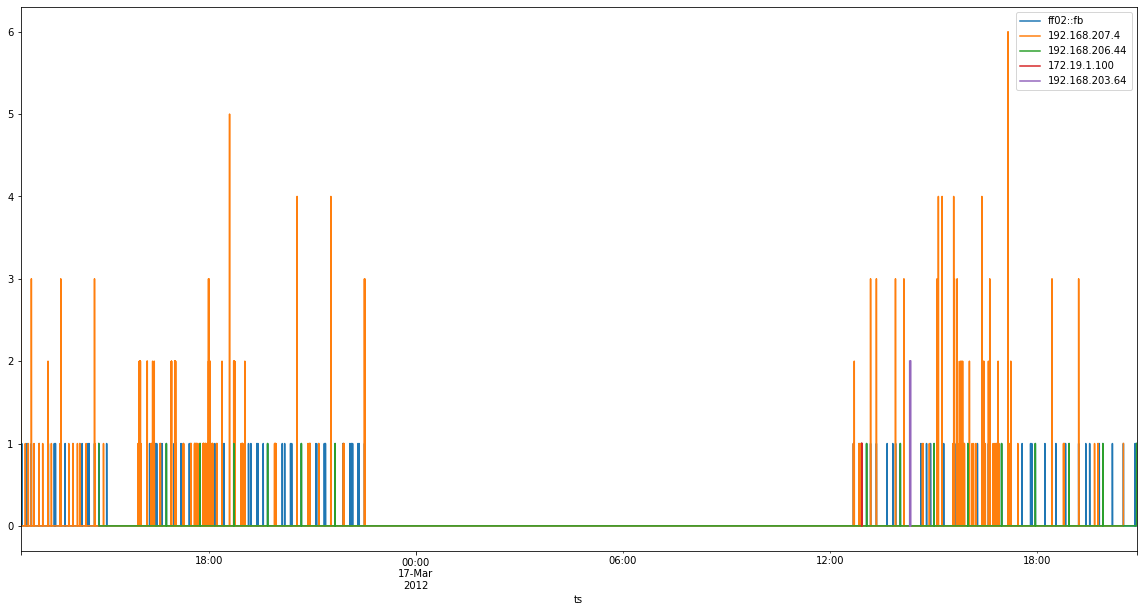

In [21]:
# Visualizing the abnormally long queries over time, seperated by destination IP
for ip in odd_dest_ips:
    dns_df[(dns_df['id.resp_h'] == ip) & (dns_df['query_len'] >=70)]['uid'].resample('1S').count().plot(label=ip,figsize=(20,10));
plt.legend(loc='upper right');
plt.show();

Thats pretty busy, let's narrow it down to the top two IPv4 addresses (in terms of connections) that we found previosuly and re-view the graph.

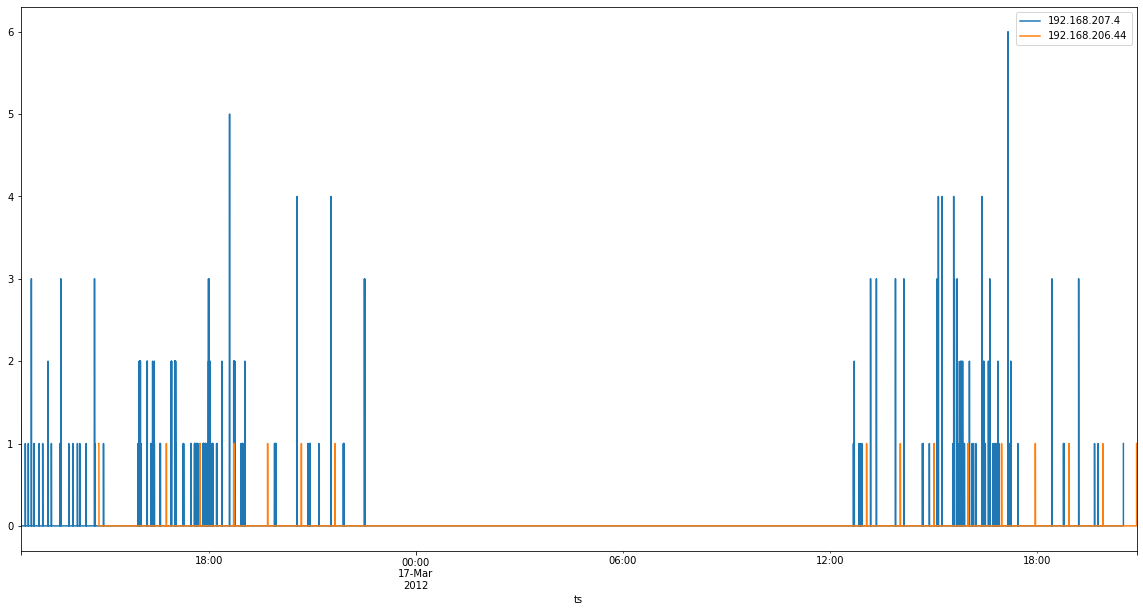

In [22]:
# Pared down visualization to two specific destination IPs
for ip in odd_dest_ips[1:3]:
    dns_df[(dns_df['id.resp_h'] == ip) & (dns_df['query_len'] >=70)]['uid'].resample('1S').count().plot(label=ip,figsize=(20,10));
plt.legend(loc='upper right');
plt.show();

This behavior is beginning to look like two different potential command and control channels communicating over DNS, which is a known technique. In fact, it looks like one, `192.168.207.4`, is being far more aggerssive in it's communication in terms of volume and frequency while the other is adopting a "low and slow" approach. This is a strategy that attackers so that the agressive channel draws attention while the other can remain active and undetected. 

To investigate further it would be helpful to know the local DNS server IP. We don't have any way to know for sure, but a good way to check would be to find the most common IP for DNS requests. In a normal network, that would be your local DNS server. Let's do that check:

In [23]:
dns_df.groupby('id.resp_h')['uid'].nunique().sort_values(ascending=False).head(10)

id.resp_h
192.168.207.4      112822
192.168.202.255     12501
172.19.1.100         7266
ff02::1:3            7216
8.26.56.26           2376
156.154.70.22        2317
68.87.75.198         2113
68.87.64.150         2046
192.168.206.44       1814
ff02::fb             1016
Name: uid, dtype: int64

Interesting, so we see that `192.168.207.4` is the most common destination IP and `192.168.206.44` is further down the list. This would indicate `192.168.207.4` could be our local DNS server, but there are several other IPs that received DNS queries as well. Let's go one level deeper.

If `192.168.207.4` is our local DNS server, we would also expect to see it communicating with an external DNS server. In this case, we know there is traffic directed to the Google DNS servers, `8.8.8.8` and `8.8.4.4` that we can use to test this theory. Let's check if those IPs appear in the destination IP list:

In [24]:
dns_df[dns_df['id.orig_h'] == '192.168.207.4'].groupby('id.resp_h')['uid'].nunique().sort_values(ascending=False).head()

id.resp_h
192.168.206.44              30
224.0.0.251                  2
fe80::c62c:3ff:fe30:7333     0
192.168.24.181               0
192.168.24.183               0
Name: uid, dtype: int64

Odd, they do not. So unfortunately at this point we can't confirm if `192.168.207.4` is our local DNS server or not. In a real-world scenario we would be able to get this information from the network owner or maintainer. However, in the absence of these answers, we have enough information to at least label the two IPs as suspicious. We will also make a mental note to circle back to investigate the other IPs that had large amounts of DNS traffic.

In [25]:
# Creating a list of our suspect IPs from the slice of our odd destination IP list
suspect_ips = odd_dest_ips[1:3]

Now that we have a set of suspicious IPs, we want to understand when they began communicating with our network and what other IPs they are communicating with. This will help us understand the scope of the potential compromise. To answer these questions we will turn to the Zeek `conn.log` which shows all the connections that occured in the PCAP.   

### Analyzing a Zeek CONN Log

The Conn log is generally the largest log that Bro will produce, making it difficult to use as a starting point for our analysis. However, now that we have a hypothesis about some malicious IPs that we would like to investigate we can turn to the Conn log to get further information. Being quite large, it will take some time to load. 

In [26]:
%%time
# Pull the conn.log into a pandas dataframe
conn_df = log_to_df.create_dataframe('./conn.log')

Wall time: 5min 33s


Here we can see that we have over 22.5 million lines in the `conn.log` and below that the type of information in the log. 

In [27]:
# Checking the length of the log
len(conn_df)

22694356

In [28]:
conn_df.head()

,uid,id.orig_h,id.orig_p,id.resp_h,id.resp_p,proto,service,duration,orig_bytes,resp_bytes,conn_state,local_orig,missed_bytes,history,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes,tunnel_parents
ts,,,,,,,,,,,,,,,,,,,
2012-03-16 12:30:00.000000000,CCUIP21wTjqkj8ZqX5,192.168.202.79,50463,192.168.229.251,80,tcp,NaN,NaT,NaN,NaN,SH,NaN,0,Fa,1,52,1,52,(empty)
2012-03-16 12:30:00.000000000,Csssjd3tX0yOTPDpng,192.168.202.79,46117,192.168.229.254,443,tcp,NaN,NaT,NaN,NaN,SF,NaN,0,dDafFr,3,382,9,994,(empty)
2012-03-16 12:30:00.000000000,CHEt7z3AzG4gyCNgci,192.168.202.79,50465,192.168.229.251,80,tcp,http,00:00:00.010000,166,214,SF,NaN,0,ShADfFa,4,382,3,382,(empty)
2012-03-16 12:30:00.009999990,CKnDAp2ohlvN6rpiXl,192.168.202.79,50467,192.168.229.251,80,tcp,http,00:00:00.010000,166,214,SF,NaN,0,ShADfFa,4,382,3,382,(empty)
2012-03-16 12:30:00.000000000,CGUBcoXKxBE8gTNl,192.168.202.79,46119,192.168.229.254,443,tcp,ssl,00:00:00.020000,544,1060,SF,NaN,0,ShADadfFr,8,968,13,1744,(empty)


Again, we will start by getting an overview of the data to look for anything that immediately stands out. We can start by viewing the number of connections by protocol over time. We would expect to primarily see TCP traffic, with some UDP and ICMP. Any spikes of UDP traffic beyond TCP at the same time would warrant investigation. In this case, we don't see anything that jumps out in the graph below. 

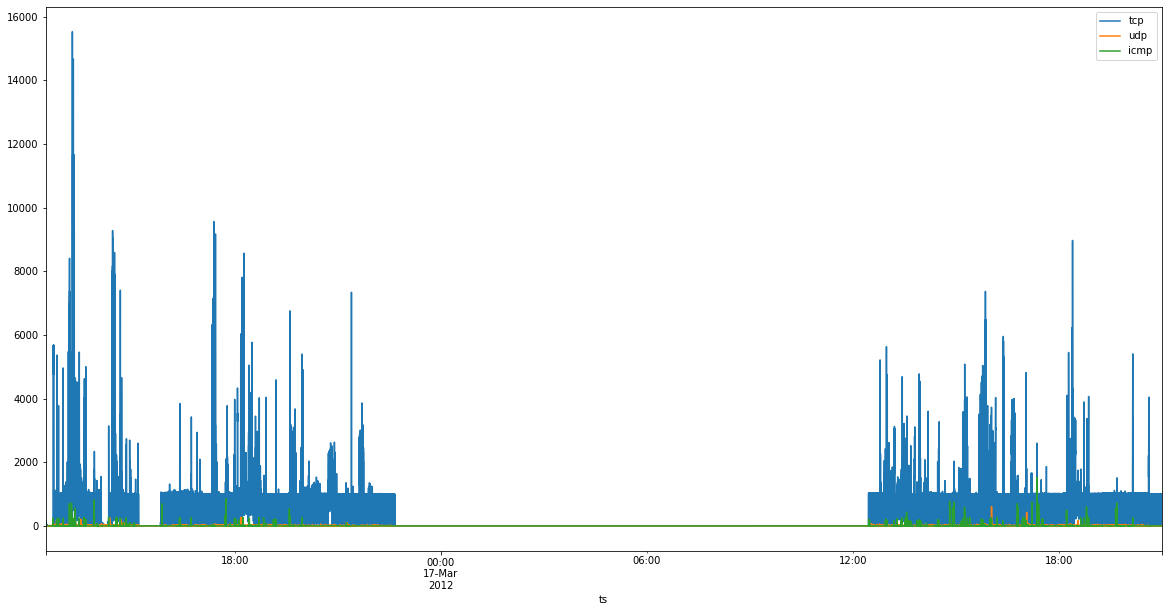

In [29]:
# Visulize the connections over time, separated by protocol type
protos = list(conn_df['proto'].unique())
for p in protos:
    conn_df[conn_df['proto'] == p]['uid'].resample('1S').count().plot(label=p,figsize=(20,10))
plt.legend(loc='upper right');
plt.show();

The second overview that we will check before diving in is the number of response bytes over time. Large spikes represent large volumes of inbound data. In the graph below we see some spikes which is interesting and could warrant further investigation later. 

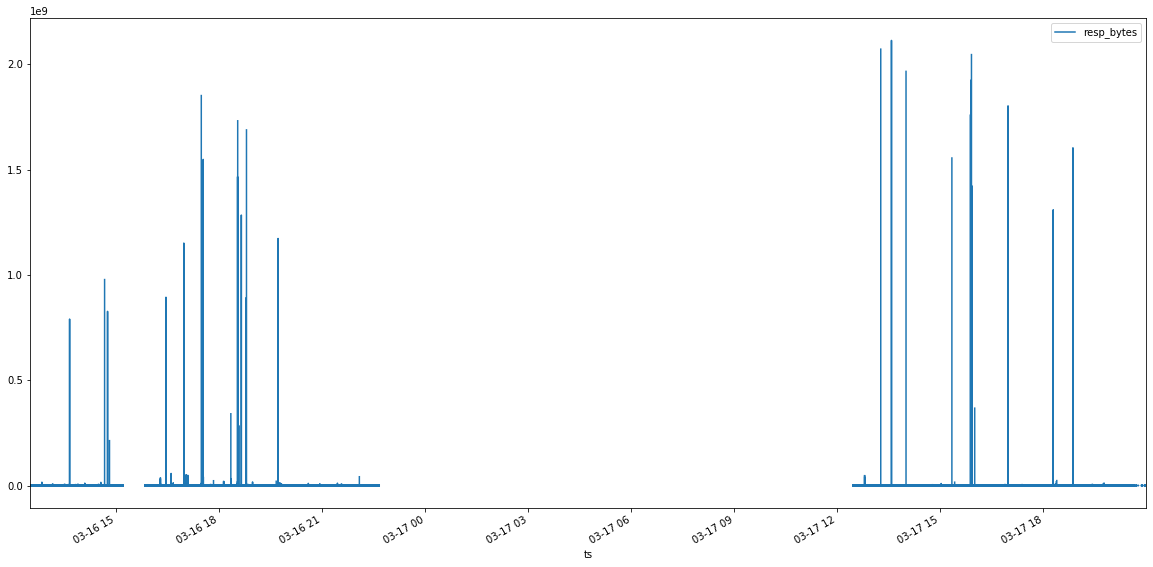

In [30]:
# Visulaize the response bytes over time
conn_df['resp_bytes'].plot(figsize=(20,10))
plt.legend(loc='upper right');
plt.show();

Before we spin off in another direction, we will get back to our list of suspect IPs from the DNS logs. Let's see how many IPs communicated with our two suspect IPs. As we find below, our quick search in the DNS log helped us cut the list by over a third. 

In [31]:
possible = list(conn_df[conn_df['id.resp_h'].isin(suspect_ips)]['id.orig_h'].unique())
print("There are %s IPs that communicated with the Suspect IPs" %len(possible))

# Compared to the total number of originating IPs
print("There are %s total unique IPs in the conn.log" %conn_df['id.orig_h'].nunique())

There are 113 IPs that communicated with the Suspect IPs
There are 379 total unique IPs in the conn.log


Let's check which IPs in our new list are sending the most data to our Suspect IPs. We will then visualize that communication over time. 

In [32]:
# lets get our top 10 talkers who intereacted with suspects
top_talkers = conn_df[conn_df['id.orig_h'].isin(possible)].groupby('id.orig_h')['orig_bytes'].sum().nlargest(10)
print(top_talkers)

id.orig_h
192.168.202.102    552005584177
192.168.202.140    436083405435
192.168.202.4      215991733567
192.168.202.110    114476154847
192.168.202.80      99452101267
192.168.202.79      96851788724
192.168.202.138     27973707785
192.168.202.144     10749054397
192.168.202.98       5329768824
192.168.203.61       1929647890
Name: orig_bytes, dtype: UInt64


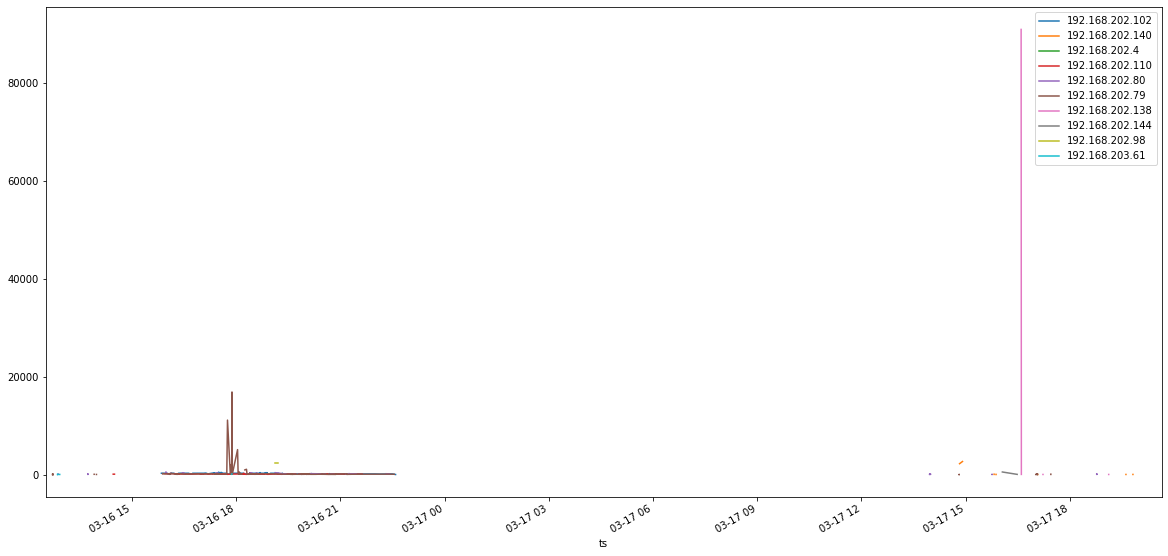

In [33]:
# Visualize the volume of data sent from the top talkers to our suspect IPs over time
top_talk_list = top_talkers.index.values.tolist()
for host in top_talk_list:
    conn_df[(conn_df['id.orig_h'] == host) & (conn_df['id.resp_h'].isin(suspect_ips))]['orig_bytes'].plot(label=host,figsize=(20,10))
plt.legend(loc='upper right');
plt.show();

Great, so our visualization brings two interesting behaviors to the forefront. The first is the burst of traffic from `192.168.202.79` and the second is the large spike from `192.168.202.138`. Let's see if we can learn about that traffic. 

In [34]:
# Check protocol and service breakdown when interacting with Suspect IPs
investigate = ['192.168.202.79','192.168.202.138']
inv_df = conn_df[(conn_df['id.orig_h'].isin(investigate)) & (conn_df['id.resp_h'].isin(suspect_ips))]
inv_df.groupby(['proto','service']).first()

duration  id.orig_p  id.resp_p  missed_bytes  \
proto service                                                        
icmp  dhcp                 NaT        NaN        NaN           NaN   
      dns                  NaT        NaN        NaN           NaN   
      http                 NaT        NaN        NaN           NaN   
      ssh                  NaT        NaN        NaN           NaN   
      ssl                  NaT        NaN        NaN           NaN   
      smtp                 NaT        NaN        NaN           NaN   
      ftp                  NaT        NaN        NaN           NaN   
      ftp-data             NaT        NaN        NaN           NaN   
      pop3                 NaT        NaN        NaN           NaN   
tcp   dhcp                 NaT        NaN        NaN           NaN   
      dns                  NaT        NaN        NaN           NaN   
      http                 NaT        NaN        NaN           NaN   
      ssh                  NaT        NaN        NaN           NaN   
      ssl                  NaT        NaN        NaN           NaN   
      smtp                 NaT        NaN        NaN           NaN   
      ftp                  NaT        NaN        NaN           NaN   
      ftp-data             NaT        NaN        NaN           NaN   
      pop3                 NaT        NaN        NaN           NaN   
udp   dhcp                 NaT        NaN        NaN           NaN   
      dns      00:00:00.010000    58115.0       53.0           0.0   
      http                 NaT        NaN        NaN           NaN   
      ssh                  NaT        NaN        NaN           NaN   
      ssl                  NaT        NaN        NaN           NaN   
      smtp                 NaT        NaN        NaN           NaN   
      ftp                  NaT        NaN        NaN           NaN   
      ftp-data             NaT        NaN        NaN           NaN   
      pop3                 NaT        NaN        NaN           NaN   

                orig_bytes  orig_ip_bytes  orig_pkts  resp_bytes  \
proto service                                                      
icmp  dhcp             NaN            NaN        NaN         NaN   
      dns              NaN            NaN        NaN         NaN   
      http             NaN            NaN        NaN         NaN   
      ssh              NaN            NaN        NaN         NaN   
      ssl              NaN            NaN        NaN         NaN   
      smtp             NaN            NaN        NaN         NaN   
      ftp              NaN            NaN        NaN         NaN   
      ftp-data         NaN            NaN        NaN         NaN   
      pop3             NaN            NaN        NaN         NaN   
tcp   dhcp             NaN            NaN        NaN         NaN   
      dns              NaN            NaN        NaN         NaN   
      http             NaN            NaN        NaN         NaN   
      ssh              NaN            NaN        NaN         NaN   
      ssl              NaN            NaN        NaN         NaN   
      smtp             NaN            NaN        NaN         NaN   
      ftp              NaN            NaN        NaN         NaN   
      ftp-data         NaN            NaN        NaN         NaN   
      pop3             NaN            NaN        NaN         NaN   
udp   dhcp             NaN            NaN        NaN         NaN   
      dns             36.0          110.0        1.0        93.0   
      http             NaN            NaN        NaN         NaN   
      ssh              NaN            NaN        NaN         NaN   
      ssl              NaN            NaN        NaN         NaN   
      smtp             NaN            NaN        NaN         NaN   
      ftp              NaN            NaN        NaN         NaN   
      ftp-data         NaN            NaN        NaN         NaN   
      pop3             NaN            NaN        NaN         NaN   

                re

Ok, so they were only communicating with our Suspect IPs over DNS. Let's see if they were doing anything interesting with another IP. Let's drop the filter for communication with the Suspect IPS and 

In [35]:
# Check protocol and service breakdown with suspect IP filter removed
inv_df = conn_df[(conn_df['id.orig_h'].isin(investigate))]
inv_df.groupby(['proto','service']).first()

duration  id.orig_p  id.resp_p  missed_bytes  \
proto service                                                        
icmp  dhcp                 NaT        NaN        NaN           NaN   
      dns                  NaT        NaN        NaN           NaN   
      http                 NaT        NaN        NaN           NaN   
      ssh                  NaT        NaN        NaN           NaN   
      ssl                  NaT        NaN        NaN           NaN   
      smtp                 NaT        NaN        NaN           NaN   
      ftp                  NaT        NaN        NaN           NaN   
      ftp-data             NaT        NaN        NaN           NaN   
      pop3                 NaT        NaN        NaN           NaN   
tcp   dhcp                 NaT        NaN        NaN           NaN   
      dns      00:00:06.010000    53141.0       53.0           0.0   
      http     00:00:00.010000    50465.0       80.0           0.0   
      ssh      00:00:00.020000    44642.0       22.0           0.0   
      ssl      00:00:00.020000    46119.0      443.0           0.0   
      smtp     00:00:00.370000    44926.0       25.0           0.0   
      ftp      00:00:20.060000    35096.0       21.0           0.0   
      ftp-data 00:00:00.160000    53448.0    49672.0           0.0   
      pop3                 NaT        NaN        NaN           NaN   
udp   dhcp     00:00:00.010000       68.0       67.0           0.0   
      dns      00:00:00.010000    58115.0       53.0           0.0   
      http                 NaT        NaN        NaN           NaN   
      ssh                  NaT        NaN        NaN           NaN   
      ssl                  NaT        NaN        NaN           NaN   
      smtp                 NaT        NaN        NaN           NaN   
      ftp                  NaT        NaN        NaN           NaN   
      ftp-data             NaT        NaN        NaN           NaN   
      pop3                 NaT        NaN        NaN           NaN   

                orig_bytes  orig_ip_bytes  orig_pkts  resp_bytes  \
proto service                                                      
icmp  dhcp             NaN            NaN        NaN         NaN   
      dns              NaN            NaN        NaN         NaN   
      http             NaN            NaN        NaN         NaN   
      ssh              NaN            NaN        NaN         NaN   
      ssl              NaN            NaN        NaN         NaN   
      smtp             NaN            NaN        NaN         NaN   
      ftp              NaN            NaN        NaN         NaN   
      ftp-data         NaN            NaN        NaN         NaN   
      pop3             NaN            NaN        NaN         NaN   
tcp   dhcp             NaN            NaN        NaN         NaN   
      dns             32.0          404.0        7.0        57.0   
      http           166.0          382.0        4.0       214.0   
      ssh              0.0          268.0        5.0        39.0   
      ssl            544.0          968.0        8.0      1060.0   
      smtp            34.0          614.0       11.0       622.0   
      ftp              4.0          380.0        8.0       152.0   
      ftp-data         0.0          268.0        5.0       122.0   
      pop3             NaN            NaN        NaN         NaN   
udp   dhcp           300.0          633.0        2.0       300.0   
      dns             36.0          110.0        1.0        93.0   
      http             NaN            NaN        NaN         NaN   
      ssh              NaN            NaN        NaN         NaN   
      ssl              NaN            NaN        NaN         NaN   
      smtp             NaN            NaN        NaN         NaN   
      ftp              NaN            NaN        NaN         NaN   
      ftp-data         NaN            NaN        NaN         NaN   
      pop3             NaN            NaN        NaN         NaN   

                re

Interesting, we see that they were using the File Transfer Protocol (FTP) to send data as seen in the `ftp-data` row. Let's see what we can learn quickly.

In [36]:
# Look at the ftp-data connections from the local IPs we were investigating
inv_df[(inv_df['proto'] == 'tcp') & (inv_df['service'] == 'ftp-data')]

,uid,id.orig_h,id.orig_p,id.resp_h,id.resp_p,proto,service,duration,orig_bytes,resp_bytes,conn_state,local_orig,missed_bytes,history,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes,tunnel_parents
ts,,,,,,,,,,,,,,,,,,,
2012-03-16 17:55:14.359999895,CmQIeg1m1CwQBtHT5l,192.168.202.79,53448,192.168.26.103,49672,tcp,ftp-data,00:00:00.160000,0,122,SF,NaN,0,ShAdfFa,5,268,4,338,(empty)
2012-03-16 17:55:53.329999924,CpMlir6N4WSYKBoxe,192.168.202.79,55550,192.168.26.101,32813,tcp,ftp-data,00:00:00.160000,0,61,SF,NaN,0,ShAdfFa,5,268,4,277,(empty)
2012-03-16 18:03:20.349999905,CKxcnQdJgKqaVOXGd,192.168.202.79,51928,192.168.27.101,58020,tcp,ftp-data,00:00:00.150000,0,61,SF,NaN,0,ShAdfFa,5,268,4,277,(empty)
2012-03-17 18:48:46.190000057,CFRXYI17OF9OOyL5t,192.168.202.138,40101,192.168.27.103,49302,tcp,ftp-data,00:00:03,0,0,S0,NaN,0,S,3,180,0,0,(empty)
2012-03-17 18:48:46.200000048,CT0FbVnZYioauvlA6,192.168.202.138,52641,192.168.27.103,49303,tcp,ftp-data,00:00:03,0,0,S0,NaN,0,S,3,180,0,0,(empty)


So it looks like we have two source IPs, `192.168.202.79` and `192.168.202.138`, making ftp-data connection with two destination IPs, `192.168.26.101` and `192.168.26.103`. Depending on the organization, FTP transfers may or may not be common so we cannot be sure if this is malicious. However, FTP can be used by attackers for either tool downloads or data exfiltration, so this behavior would at least warrant further investigation.

## Summary

At this point I am sure you are noticing a trend: there is always something further to investigate! Unfortunately we don't have a satisfying conclusion to the story, however this is virtually always the case in the security field. We rarely, if ever, have an absolute baseline for measurement or get perfect confirmation of malicious behavior. Instead, analysts use their domain knowledge and analytic process and tools to continue to pull at threads and build the best understand that they can of what is occuring in their network. 

I hope you leave this tutorial with more insights into the challenges, methodologies, and tools used to analyze network data! We only scartched the surface of the techniques that we can leverage against the security problem set. With the Zeek logs in pandas data frames there are endless possibilities to merge different logs, leverage additional tool sets like SK Learn, or apply other data science techniques covered in the course.

For more information on methodologies and tools, please take a look at the [References](#References) section. If you decide to apply these skills yourself, happy hunting!

### References

1. Bro Analysis Tools: https://github.com/SuperCowPowers/bat 
2. Example ML application: https://www.zeek.org/brocon2017/slides/machine_learning.pdf
5. Network security analysis walkthrough and thought process: https://www.youtube.com/watch?v=R5mnIvjQn-g

### **Appendix: Basic Zeek Installation Guide**

Get the neccesary dependencies. These are the dependencies for Debian based Linux. Dependencies for other systems can be found [here](https://docs.zeek.org/en/stable/install/install.html#id1). Be aware that building from source will take some time, if you are looking to quickly use the toolset you can `apt` install an older version of the Bro framework. 

More detailed installtion information can be found [HERE](https://docs.zeek.org/en/stable/install/install.html)